# Importing Libraries

In [1]:
import pandas as pd
import random
import numpy as np
import matplotlib.pyplot as plt
import datetime
import seaborn as sns

In [2]:
%run "Stock Data.ipynb".ipynb
%run "Binance API.ipynb".ipynb
%run "RiskMetrics.ipynb".ipynb

# Importing Data

## Tickers

In [3]:
binance_api_key='E90xR7UnO2oeP3lrgC50zkqUuAqyyXs4uSlAGcqIVO9n90ELrFI4gfVI2HGGxxCj'
binance_api_secret='Inls2xYl9FqPi0zlIrucfxG81drx7w6Pv6SzYFxMNoAcwDjlCKug7zUM9zB3lF9h'
Binance=BinanceAPI(binance_api_key,binance_api_secret)

In [4]:
#stocks=pd.read_html('https://en.wikipedia.org/wiki/EURO_STOXX_50')[4]
#tickers=stocks['Ticker'].to_list()

## Market Data

In [5]:
start_date=datetime.datetime(2023,12,1)
enddate=start_date+datetime.timedelta(500)

In [6]:
tickers=Binance.get_market_cap()['Ticker'].iloc[:75].to_list()
holding=Binance.get_inventory()
condition=holding.index!='Total'
holding_tickers=holding.index[condition]
holding_tickers=holding_tickers.to_list()
tickers=sorted(list(set(tickers+holding_tickers)))
holding.round(5)

,Price in USDT,Weights in %
Total,1762.30636,1.00000
BTCUSDT,596.18780,0.33830
TRXUSDT,283.10072,0.16064
JASMYUSDT,243.32099,0.13807
SOLUSDT,243.16008,0.13798
OMUSDT,190.81486,0.10828
ETHUSDT,173.96698,0.09872
BBUSDT,31.73396,0.01801
BNBUSDT,0.02095,0.00001
PEPEUSDT,0.00000,0.00000


In [7]:
data1=Binance.get_price(tickers,start_date)
data2=Binance.get_price(tickers,enddate)
data=data1.combine_first(data2)
data.index=pd.to_datetime(data.index)
#data=data.dropna(axis=1)
n=len(data.columns)
data=data.sort_index()

In [8]:
inventory_weights=(holding['Weights in %'].apply(lambda x: np.round(x,2))).to_dict()
inventory_weights.pop('Total')

if "USDTUSDT" in inventory_weights:
    
    inventory_weights.pop('USDTUSDT')
else: 
    pass

In [9]:
returns=np.log(1+data.pct_change())
returns.index=pd.to_datetime(returns.index)
with_no_na=returns.columns[np.where((returns.isna().sum()<30))]
returns_to_use=returns[with_no_na]
ex_ante_perf=returns[holding_tickers]
ex_ante_perf_to_use=ex_ante_perf.dropna()

In [10]:
weights_post=dict()

for col in ex_ante_perf.columns:
    
    if col in inventory_weights.keys():
        weights_post[col]=inventory_weights[col]
        
    else:
        weights_post[col]=0
    
current_weights=np.array(list(weights_post.values()))
current_weights=np.round(current_weights,2)/np.sum(np.round(current_weights,2))

### Positions

In [11]:
position=pd.read_excel('Positions.xlsx',index_col=0)

In [12]:
positions=Binance.get_positions_history(enddate=datetime.datetime.today(),
                                        startdate=datetime.datetime(2024,5,5))


2024-05-05 00:00:00
2024-06-04 00:00:00
2024-07-04 00:00:00
2024-08-03 00:00:00
LDUMAUSDT not retrieved
LDTRXUSDT not retrieved
LDUMAUSDT
LDTRXUSDT


In [13]:
positions=positions.sort_index()

In [14]:
positions.index=pd.to_datetime(positions.index)

In [15]:
positions=pd.concat([position,positions])
positions=positions.loc[~positions.index.duplicated(),:]

In [16]:
positions.to_excel('Positions.xlsx')

In [17]:
positions=positions.interpolate()
positions['Total']=positions.sum(axis=1)

In [18]:
ptf_tickers=list(positions.columns)
ptf_tickers.remove('USDTUSDT')

In [19]:
weights_ex_post=positions.copy()
weights_ex_post=weights_ex_post.drop(columns=['USDTUSDT'])
weights_ex_post=weights_ex_post.apply(lambda x: x/weights_ex_post['Total'])

In [20]:
binance_data=Binance.get_price(ptf_tickers,date=datetime.datetime(2024,5,11))
binance_data.index=pd.to_datetime(binance_data.index)
binance_data=binance_data.sort_index()
binance_data=np.log(1+binance_data.pct_change())


LDUMAUSDT not retrieved
Total not retrieved


In [21]:
weight_date=set(weights_ex_post.index)
binance_date=binance_data.index

In [22]:
common_date=binance_date.intersection(weight_date)

binance_data=binance_data.loc[common_date]

In [23]:
historical_ptf=pd.DataFrame()

for col in binance_data:
    historical_ptf[col]=weights_ex_post[col]*binance_data[col]
    
historical_ptf['Historical Portfolio']=historical_ptf.sum(axis=1)

<AxesSubplot:>

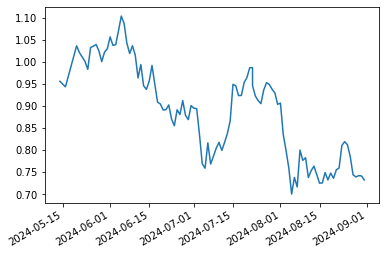

In [24]:
#historical_ptf.dropna(axis = 0, how = 'all', inplace = True)

(1+historical_ptf['Historical Portfolio']).cumprod().plot()

### Ex ante data

In [25]:
ex_ante_ptf=ex_ante_perf.copy()

for key in inventory_weights.keys():
    
    ex_ante_ptf[key]=ex_ante_perf[key]*inventory_weights[key]

ex_ante_ptf=pd.DataFrame(ex_ante_ptf.sum(axis=1))

# Portfolio Optimization

In [26]:
historical_risk=RiskAnalysis(returns_to_use)
current_risk=RiskAnalysis(ex_ante_perf_to_use.iloc[:])
num_asset=len(returns_to_use.columns)
num_asset_current=len(ex_ante_perf_to_use.columns)

In [27]:
returns_to_use.columns

Index(['1000SATSUSDT', 'AAVEUSDT', 'ADAUSDT', 'ALGOUSDT', 'APTUSDT', 'ARBUSDT',
       'ARUSDT', 'ATOMUSDT', 'AVAXUSDT', 'AXSUSDT', 'BCHUSDT', 'BNBUSDT',
       'BONKUSDT', 'BTCUSDT', 'DOGEUSDT', 'DOTUSDT', 'EGLDUSDT', 'ENSUSDT',
       'EOSUSDT', 'ETCUSDT', 'ETHUSDT', 'FDUSDUSDT', 'FETUSDT', 'FILUSDT',
       'FLOKIUSDT', 'FLOWUSDT', 'FTMUSDT', 'GALAUSDT', 'GRTUSDT', 'HBARUSDT',
       'ICPUSDT', 'IMXUSDT', 'INJUSDT', 'JASMYUSDT', 'LDOUSDT', 'LINKUSDT',
       'LTCUSDT', 'MATICUSDT', 'MKRUSDT', 'NEARUSDT', 'NEOUSDT', 'OMUSDT',
       'OPUSDT', 'ORDIUSDT', 'PEPEUSDT', 'QNTUSDT', 'RUNEUSDT', 'SEIUSDT',
       'SHIBUSDT', 'SOLUSDT', 'STXUSDT', 'SUIUSDT', 'THETAUSDT', 'TIAUSDT',
       'TRXUSDT', 'UNIUSDT', 'USDCUSDT', 'VETUSDT', 'WBETHUSDT', 'WBTCUSDT',
       'WLDUSDT', 'XECUSDT', 'XLMUSDT', 'XRPUSDT', 'XTZUSDT'],
      dtype='object')

In [28]:
limit=np.where(returns_to_use.columns=='BTCUSDT')[0][0],np.where(returns_to_use.columns=='ETHUSDT')[0][0],np.where(returns_to_use.columns=='SOLUSDT')[0][0]

## Optimal Portfolio

In [29]:
opt_weights=historical_risk.optimize(objective="sharpe_ratio",constraints=[{'type': 'ineq', 'fun': lambda weights: weights[limit[0]]-0.40}])
                                                         #  ,{'type': 'ineq', 'fun': lambda weights: weights[limit[1]]-0.15},
                                                        #{'type': 'ineq', 'fun': lambda weights: weights[limit[2]]-0.15}])
opt_weights=np.round(opt_weights,6)
inventory=historical_risk.inventory(opt_weights)
inventory

,Weights
OMUSDT,0.477863
BTCUSDT,0.400000
PEPEUSDT,0.068381
BNBUSDT,0.042247
JASMYUSDT,0.011510


In [30]:
limit=np.where(ex_ante_perf_to_use.columns=='BTCUSDT')[0][0],np.where(ex_ante_perf_to_use.columns=='ETHUSDT')[0][0],np.where(ex_ante_perf_to_use.columns=='SOLUSDT')[0][0]

In [31]:
current_optimal_weights=current_risk.optimize(objective="sharpe_ratio")#,constraints=[{'type': 'ineq', 'fun': lambda weights: weights[limit[0]]-0.40}])
                                                           #,{'type': 'ineq', 'fun': lambda weights: weights[limit[1]]-0.15},
                                                            #{'type': 'ineq', 'fun': lambda weights: weights[limit[2]]-0.15}])
current_optimal_weights=np.round(current_optimal_weights,6)
optimal_ptf_current=current_risk.inventory(current_optimal_weights)
optimal_ptf_current

,Weights
TRXUSDT,0.898312
OMUSDT,0.101688


## Real Portfolio vs Optimal

In [32]:
current_holding_comparison=holding.copy()
current_holding_comparison=current_holding_comparison.loc[current_holding_comparison.index!="Total"]
current_holding_comparison=pd.concat([current_holding_comparison,optimal_ptf_current],axis=1)
current_holding_comparison['Spread']=current_holding_comparison['Weights in %']-current_holding_comparison['Weights']
current_holding_comparison=current_holding_comparison.fillna(0)
current_holding_comparison

,Price in USDT,Weights in %,Weights,Spread
BTCUSDT,596.187805,3.382998e-01,0.000000,0.000000
TRXUSDT,283.100723,1.606422e-01,0.898312,-0.737670
JASMYUSDT,243.320992,1.380696e-01,0.000000,0.000000
SOLUSDT,243.160077,1.379783e-01,0.000000,0.000000
OMUSDT,190.814864,1.082756e-01,0.101688,0.006588
ETHUSDT,173.966982,9.871552e-02,0.000000,0.000000
BBUSDT,31.733964,1.800706e-02,0.000000,0.000000
BNBUSDT,0.020951,1.188821e-05,0.000000,0.000000
PEPEUSDT,0.000002,1.029560e-09,0.000000,0.000000


In [33]:
historical_comparison=holding.copy()
historical_comparison=historical_comparison.loc[historical_comparison.index!="Total"]
historical_comparison=pd.concat([historical_comparison,inventory],axis=1)
historical_comparison['Spread']=historical_comparison['Weights in %']-historical_comparison['Weights']
historical_comparison=historical_comparison.fillna(0)
historical_comparison

,Price in USDT,Weights in %,Weights,Spread
BTCUSDT,596.187805,3.382998e-01,0.400000,-0.061700
TRXUSDT,283.100723,1.606422e-01,0.000000,0.000000
JASMYUSDT,243.320992,1.380696e-01,0.011510,0.126560
SOLUSDT,243.160077,1.379783e-01,0.000000,0.000000
OMUSDT,190.814864,1.082756e-01,0.477863,-0.369587
ETHUSDT,173.966982,9.871552e-02,0.000000,0.000000
BBUSDT,31.733964,1.800706e-02,0.000000,0.000000
BNBUSDT,0.020951,1.188821e-05,0.042247,-0.042235
PEPEUSDT,0.000002,1.029560e-09,0.068381,-0.068381


## Risk Reward Analysis

In [34]:
opt_ptf=(returns_to_use*opt_weights).sum(axis=1)
curr_opt_ptf=(ex_ante_perf*current_optimal_weights).sum(axis=1)
portfolio_perf=pd.DataFrame()
portfolio_perf['Portfolio']=(ex_ante_perf*current_weights).sum(axis=1)

In [35]:
portfolio_perf['Bitcoin']=returns['BTCUSDT']
portfolio_perf['Optimal']=opt_ptf
portfolio_perf['Current Optimal']=curr_opt_ptf

<AxesSubplot:>

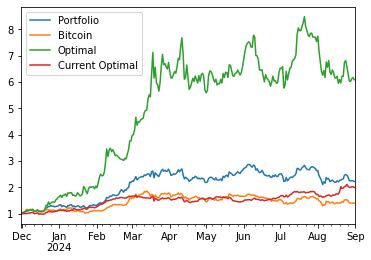

In [36]:
(1+portfolio_perf.iloc[:]).cumprod().plot()

In [37]:
current_perf=portfolio_perf.copy()
current_perf=current_perf.loc[historical_ptf.index]
current_perf['Historical Portfolio']=historical_ptf['Historical Portfolio']

<AxesSubplot:>

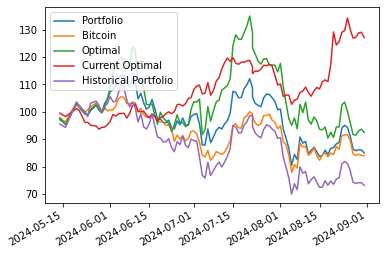

In [38]:
((1+current_perf.iloc[:]).cumprod()*100).plot()

In [39]:
((1+current_perf).cumprod()*100).iloc[-10:]

,Portfolio,Bitcoin,Optimal,Current Optimal,Historical Portfolio
2024-08-22,88.874393,86.363205,94.531657,125.564181,76.000152
2024-08-23,94.180587,91.447904,102.574055,129.024395,81.091030
2024-08-24,95.167077,91.618781,103.575455,129.645632,81.956249
2024-08-25,94.363021,91.708689,100.275276,134.226618,81.245356
2024-08-26,91.221556,89.707756,96.063838,129.962692,78.568301
2024-08-27,86.446936,84.688642,91.795049,126.902245,74.455873
2024-08-28,85.890193,84.145117,91.527010,127.170246,73.972108
2024-08-29,86.225807,84.605822,93.155879,128.752046,74.250621
2024-08-30,86.182560,84.270178,93.740975,129.012045,74.210191
2024-08-31,85.097972,84.056109,92.548974,127.068203,73.287799


<AxesSubplot:>

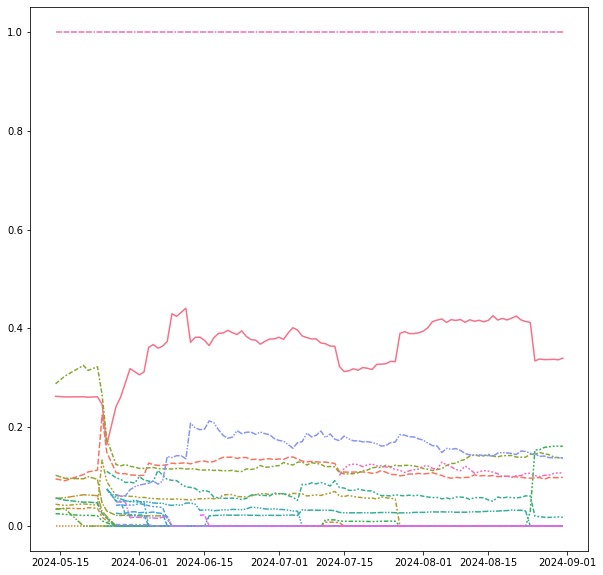

In [40]:
plt.figure(figsize=(10,10))
sns.lineplot(data=weights_ex_post,legend=False,linestyle='solid')

In [41]:
vol=historical_risk.portfolio(opt_weights).std()*np.sqrt(252)

vol

Portfolio    0.748127
dtype: float64

In [42]:
vol=current_risk.portfolio(current_weights).std()*np.sqrt(252)

vol

Portfolio    0.488206
dtype: float64

In [43]:
portfolio_perf.iloc[1:].std()*np.sqrt(252)

Portfolio          0.483461
Bitcoin            0.449665
Optimal            0.749450
Current Optimal    0.325075
dtype: float64

In [44]:
current_risk.tracking_error(current_risk.returns['BTCUSDT'],current_perf['Historical Portfolio'])

0.262447060910038

In [45]:
perf_analysis=pd.concat([historical_risk.perf_contrib_pct(opt_weights),historical_risk.var_contrib_pct(opt_weights)],axis=1)
perf_analysis

,Performance Contribution in %,Last Weights,Variance Contribution in %,Idiosyncratic Risk in %,Correlation in %
BNBUSDT,0.005554,0.009816,0.011888,0.000805,0.011083
BTCUSDT,0.020585,0.064655,0.150304,0.057599,0.092705
JASMYUSDT,0.001540,0.002698,0.006065,0.000298,0.005767
OMUSDT,0.956374,0.900795,0.776759,0.682948,0.093812
PEPEUSDT,0.015946,0.022037,0.054984,0.014700,0.040284


In [46]:
perf_analysis=pd.concat([current_risk.perf_contrib_pct(current_weights),current_risk.var_contrib_pct(current_weights)],axis=1)
perf_analysis

,Performance Contribution in %,Last Weights,Variance Contribution in %,Idiosyncratic Risk in %,Correlation in %
BTCUSDT,0.492054,0.324611,0.268788,0.086922,0.181866
TRXUSDT,-0.481639,0.207927,0.040884,0.011258,0.029626
JASMYUSDT,0.352193,0.122093,0.252867,0.089512,0.163356
SOLUSDT,0.331936,0.123660,0.171533,0.039183,0.132350
OMUSDT,-0.152912,0.129164,0.130191,0.038117,0.092073
ETHUSDT,0.284538,0.084658,0.094764,0.013221,0.081542
BBUSDT,0.173831,0.007887,0.040974,0.003826,0.037148


## Value At Risk

### Historical

In [47]:
var,cvar=historical_risk.historical_var(opt_weights)
(var,cvar)

(-0.06313267313336524, -0.08864043029921927)

In [48]:
var,cvar=current_risk.historical_var(current_weights)
(var,cvar)

(-0.051183061474598605, -0.06481829732103016)

In [49]:
historical_var=current_risk.returns*current_weights
historical_var['Portfolio']=historical_var.sum(axis=1)
historical_var=historical_var.sort_values(by='Portfolio')
centile=0.05
row=round(historical_var.shape[0]*centile)

In [50]:
var=historical_var.iloc[row]
var

BTCUSDT     -0.012444
TRXUSDT     -0.001727
JASMYUSDT   -0.011106
SOLUSDT     -0.011675
OMUSDT      -0.008975
ETHUSDT     -0.002091
BBUSDT      -0.002008
BNBUSDT     -0.000000
PEPEUSDT    -0.000000
Portfolio   -0.050025
Name: 2024-08-11 00:00:00, dtype: float64

In [51]:
cvar=historical_var.iloc[:row+1].mean()
cvar

BTCUSDT     -0.017102
TRXUSDT     -0.003912
JASMYUSDT   -0.013984
SOLUSDT     -0.010897
OMUSDT      -0.008372
ETHUSDT     -0.006362
BBUSDT      -0.002076
BNBUSDT      0.000000
PEPEUSDT     0.000000
Portfolio   -0.062705
dtype: float64

### Parametric

In [52]:
var,cvar=historical_risk.parametric_var(opt_weights)

(var,cvar)

(-0.07765507681404428, -0.09953233803596871)

In [53]:
var,cvar=current_risk.parametric_var(current_weights)

(var,cvar)

(-0.050585928757134226, -0.06483717443194807)

### Multivariate

In [54]:
perf=performance(historical_risk.multivariate_distribution(),opt_weights)
var=np.percentile(perf,5)
cvar=perf[perf<var].mean()
(var,cvar)

(-0.06989784901642071, -0.08945036345932814)

In [55]:
perf=performance(current_risk.multivariate_distribution(),current_weights)
var=np.percentile(perf,5)
cvar=perf[perf<var].mean()
(var,cvar)

(-0.05002102134046587, -0.0632691199917714)

In [56]:
scenario_multivariate={}

for i in range(50):
    multivariate_distrib=pd.DataFrame(current_risk.multivariate_distribution(),columns=current_risk.returns.columns)
    multivariate_distrib=multivariate_distrib*current_weights
    multivariate_distrib=multivariate_distrib[multivariate_distrib.columns[current_weights>0]]

    multivariate_distrib['Portfolio']=multivariate_distrib.sum(axis=1)
    multivariate_var=multivariate_distrib.sort_values(by='Portfolio').iloc[int(multivariate_distrib.shape[0]*0.05)]['Portfolio']
    results=multivariate_distrib.sort_values(by='Portfolio').iloc[int(multivariate_distrib.shape[0]*0.05)]

    scenario_multivariate[i]=results.to_dict()

mean_scenario_multivariate=pd.DataFrame(scenario_multivariate).T.mean()
mean_scenario_multivariate

BTCUSDT     -0.014529
TRXUSDT     -0.002432
JASMYUSDT   -0.010953
SOLUSDT     -0.008964
OMUSDT      -0.006274
ETHUSDT     -0.005226
BBUSDT      -0.002119
Portfolio   -0.050496
dtype: float64

### Copulas

In [57]:
cop=historical_risk.gaussian_copula()
perf=performance(cop,opt_weights)
var=np.percentile(perf,5)
cvar=perf[perf<var].mean()

var,cvar

(-0.06952892369249619, -0.08942951142497173)

In [58]:
cop=current_risk.gaussian_copula()
perf=performance(cop,current_weights)
var=np.percentile(perf,5)
cvar=perf[perf<var].mean()

var,cvar

(-0.05002616400790604, -0.06361943366048889)

In [59]:
scenario_gaussian={}

for i in range(100):
    gaussian_copula_distrib=pd.DataFrame(current_risk.gaussian_copula(),columns=current_risk.returns.columns)

    gaussian_copula_distrib=gaussian_copula_distrib*current_weights
    gaussian_copula_distrib=gaussian_copula_distrib[gaussian_copula_distrib.columns[current_weights>0]]

    gaussian_copula_distrib['Portfolio']=gaussian_copula_distrib.sum(axis=1)
    gaussian_var=gaussian_copula_distrib.sort_values(by='Portfolio').iloc[int(gaussian_copula_distrib.shape[0]*0.05)]['Portfolio']
    results=gaussian_copula_distrib.sort_values(by='Portfolio').iloc[int(gaussian_copula_distrib.shape[0]*0.05)]
    
    scenario_gaussian[i]=results
    
mean_scenario_gaussian=pd.DataFrame(scenario_gaussian).T.mean()
mean_scenario_gaussian

BTCUSDT     -0.013454
TRXUSDT     -0.002008
JASMYUSDT   -0.013214
SOLUSDT     -0.008498
OMUSDT      -0.006292
ETHUSDT     -0.004900
BBUSDT      -0.002059
Portfolio   -0.050425
dtype: float64

In [60]:
t_copula=historical_risk.t_copula()
perf=performance(t_copula,opt_weights)
var=np.percentile(perf,5)
cvar=perf[perf<var].mean()

var,cvar

(-0.06895216482889983, -0.08863880141103152)

In [61]:
t_copula=current_risk.t_copula()
perf=performance(t_copula,current_weights)
var=np.percentile(perf,5)
cvar=perf[perf<var].mean()

var,cvar

(-0.05207802930043309, -0.06646445748843559)

In [62]:
scenario_t_copula={}

for i in range(100):
    
    t_copula_distrib=pd.DataFrame(current_risk.t_copula(),columns=current_risk.returns.columns)
    t_copula_distrib=t_copula_distrib*current_weights
    t_copula_distrib=t_copula_distrib[t_copula_distrib.columns[current_weights>0]]
    t_copula_distrib['Portfolio']=t_copula_distrib.sum(axis=1)
    t_copula_var=t_copula_distrib.sort_values(by='Portfolio').iloc[int(t_copula_distrib.shape[0]*0.05)]['Portfolio']
    results=t_copula_distrib.sort_values(by='Portfolio').iloc[int(t_copula_distrib.shape[0]*0.05)]
    
    scenario_t_copula[i]=results
    
mean_scenario_gaussian=pd.DataFrame(scenario_t_copula).T.mean()
mean_scenario_gaussian

BTCUSDT     -0.014423
TRXUSDT     -0.002075
JASMYUSDT   -0.012504
SOLUSDT     -0.008790
OMUSDT      -0.006475
ETHUSDT     -0.004847
BBUSDT      -0.002264
Portfolio   -0.051379
dtype: float64

In [63]:
gumbel_copula=historical_risk.gumbel_copula()
perf=performance(gumbel_copula,opt_weights)
var=np.percentile(perf,5)
cvar=perf[perf<var].mean()

var,cvar

(-0.13861988896708294, -0.19912159740111346)

In [64]:
gumbel_copula=current_risk.gumbel_copula(theta=2)
perf=performance(gumbel_copula,current_weights)
var=np.percentile(perf,5)
cvar=perf[perf<var].mean()

var,cvar

(-0.05707001584045945, -0.07598888427781182)

In [65]:
scenario_gumbel_copula={}

for i in range(100):
    
    gumbel_copula_distrib=pd.DataFrame(current_risk.gumbel_copula(),columns=current_risk.returns.columns)
    gumbel_copula_distrib=gumbel_copula_distrib*current_weights
    gumbel_copula_distrib=gumbel_copula_distrib[gumbel_copula_distrib.columns[current_weights>0]]
    gumbel_copula_distrib['Portfolio']=gumbel_copula_distrib.sum(axis=1)
    gumbel_copula_var=gumbel_copula_distrib.sort_values(by='Portfolio').iloc[int(gumbel_copula_distrib.shape[0]*0.05)]['Portfolio']
    results=gumbel_copula_distrib.sort_values(by='Portfolio').iloc[int(gumbel_copula_distrib.shape[0]*0.05)]
    
    scenario_gumbel_copula[i]=results
    
mean_scenario_gaussian=pd.DataFrame(scenario_gumbel_copula).T.mean()
mean_scenario_gaussian

BTCUSDT     -0.015398
TRXUSDT     -0.000927
JASMYUSDT   -0.020161
SOLUSDT     -0.007701
OMUSDT      -0.008674
ETHUSDT     -0.002920
BBUSDT      -0.000739
Portfolio   -0.056520
dtype: float64

### Monte Carlo

In [66]:
spot=data[with_no_na].iloc[-1]
monte_carlo=historical_risk.monte_carlo(spot,horizon=1/250,stress_factor=1.0)
perf=performance(monte_carlo[1].fillna(0),opt_weights)

In [67]:
var=np.percentile(perf,5)
cvar=perf[perf<var].mean()

var,cvar

(-0.07985582376529025, -0.09966327858771443)

In [68]:
spot=data[ex_ante_perf.columns].iloc[-1]
monte_carlo=current_risk.monte_carlo(spot,horizon=1/250,stress_factor=1.0)
perf=performance(monte_carlo[1].fillna(0),current_weights)
var=np.percentile(perf,5)
cvar=perf[perf<var].mean()

var,cvar

(-0.05035314640000741, -0.06328238652717043)

In [69]:
spot=data[ex_ante_perf.columns].iloc[-1]

scenario_monte_carlo={}

for i in range(100):
    
    monte_carlo=current_risk.monte_carlo(spot,horizon=1/250,stress_factor=1.0)
    monte_carlo_distrib=monte_carlo[1].fillna(0)*current_weights
    monte_carlo_distrib=monte_carlo_distrib[monte_carlo_distrib.columns[current_weights>0]]
    monte_carlo_distrib['Portfolio']=monte_carlo_distrib.sum(axis=1)
    monte_carlo_var=monte_carlo_distrib.sort_values(by='Portfolio').iloc[int(monte_carlo_distrib.shape[0]*0.05)]['Portfolio']
    results=monte_carlo_distrib.sort_values(by='Portfolio').iloc[int(monte_carlo_distrib.shape[0]*0.05)]
    
    scenario_monte_carlo[i]=results
    
mean_scenario_monte_carlo=pd.DataFrame(scenario_monte_carlo).T.mean()
mean_scenario_monte_carlo

BTCUSDT     -0.013735
TRXUSDT     -0.002164
JASMYUSDT   -0.013170
SOLUSDT     -0.008616
OMUSDT      -0.006393
ETHUSDT     -0.005029
BBUSDT      -0.002336
Portfolio   -0.051443
dtype: float64

### VaR Violation

In [70]:
var_data=rolling_var(returns_to_use,opt_weights,window=30,Q=1)
var_data

,Historical,Parametric,Multivariate,Portfolio
2024-01-14,-0.060299,-0.107876,-0.090259,-0.024715
2024-01-15,-0.060299,-0.107872,-0.093090,0.016689
2024-01-16,-0.060299,-0.108535,-0.089333,0.060214
2024-01-17,-0.060299,-0.110897,-0.093777,-0.035613
2024-01-18,-0.060299,-0.112940,-0.098266,-0.034207
...,...,...,...,...
2024-08-28,-0.069110,-0.094695,-0.100804,-0.002920
2024-08-29,-0.069110,-0.095260,-0.101493,0.017797
2024-08-30,-0.069110,-0.095211,-0.099326,0.006281
2024-08-31,-0.069110,-0.094140,-0.100611,-0.012716


In [71]:
current_var_data=rolling_var(ex_ante_perf_to_use,current_weights,window=15,Q=1)
current_var_data

,Historical,Parametric,Multivariate,Portfolio
2024-05-28,-0.027072,-0.077224,-0.070761,-0.017237
2024-05-29,-0.023440,-0.074758,-0.067987,-0.008660
2024-05-30,-0.023440,-0.064377,-0.058771,0.032551
2024-05-31,-0.023440,-0.062893,-0.056629,0.014787
2024-06-01,-0.023440,-0.062764,-0.056032,0.026087
...,...,...,...,...
2024-08-28,-0.049674,-0.062990,-0.064525,-0.006440
2024-08-29,-0.049674,-0.061918,-0.063755,0.003907
2024-08-30,-0.049674,-0.060359,-0.058158,-0.000502
2024-08-31,-0.049674,-0.060962,-0.059503,-0.012585


<AxesSubplot:>

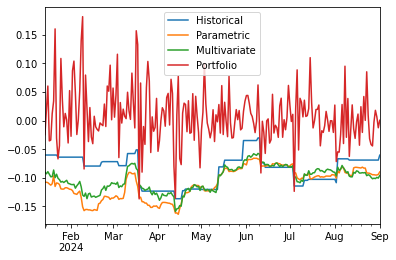

In [72]:
var_data.plot()

<AxesSubplot:>

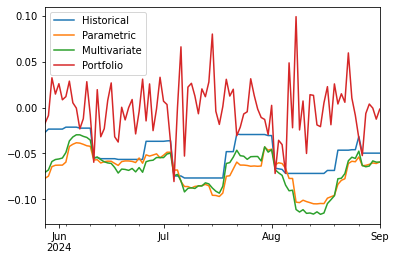

In [73]:
current_var_data.plot()

In [74]:
kupiec_test(var_data)

,Historical,Parametric,Multivariate
Proportion of failure,0.021552,0.012931,0.012931
Kupiec Stat,4.980025,9.416933,9.416933
P-value,0.025642,0.00215,0.00215


In [75]:
kupiec_test(current_var_data)

,Historical,Parametric,Multivariate
Proportion of failure,0.082474,0.041237,0.030928
Kupiec Stat,1.816331,0.166342,0.854696
P-value,0.177751,0.683384,0.355227


## Principal Component Analysis

In [76]:
eigval,eigvec,portfolio_components=historical_risk.pca(num_components=5)
variance_explained=eigval/eigval.sum()
variance_explained

array([0.77997736, 0.06727938, 0.05468783, 0.05236027, 0.04569516])

In [77]:
eigval,eigvec,portfolio_components_current=current_risk.pca(num_components=5)
variance_explained=eigval/eigval.sum()
variance_explained

array([0.66688589, 0.14227377, 0.0850704 , 0.07317251, 0.03259744])

In [78]:
pca_weight=dict((portfolio_components_current['PC1']/portfolio_components_current['PC1'].sum()))
portfolio_components_current['PC1']

BTCUSDT      0.062150
TRXUSDT      0.015583
JASMYUSDT    0.158853
SOLUSDT      0.101365
OMUSDT       0.096257
ETHUSDT      0.084363
BBUSDT       0.251007
BNBUSDT      0.068643
PEPEUSDT     0.161780
Name: PC1, dtype: float64

<AxesSubplot:>

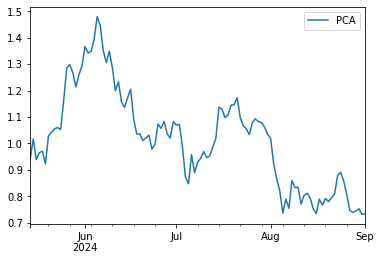

In [79]:
PCA=pd.DataFrame(np.array(list(pca_weight.values())).dot(np.transpose(current_risk.returns)),
                 index=current_risk.returns.index,
                 columns=['PCA'])
PCA=PCA.dropna()
(1+PCA).cumprod().plot()

<AxesSubplot:>

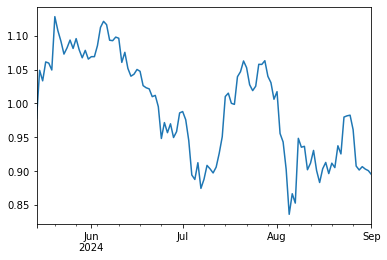

In [80]:
(1+current_risk.returns['BTCUSDT']).cumprod().plot()

In [81]:
comparison=current_risk.returns.copy()
comparison['PCA']=PCA
distances=np.sqrt(np.sum(comparison.apply(lambda y:(y-PCA['PCA'])**2))).sort_values()
distances.index[:5]

Index(['PCA', 'ETHUSDT', 'SOLUSDT', 'BNBUSDT', 'BTCUSDT'], dtype='object')

<AxesSubplot:>

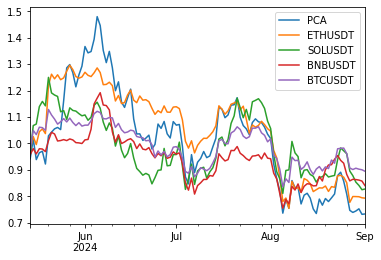

In [82]:
(1+comparison[distances.index[:5]]).cumprod().plot()

### Sensitivity Analysis

In [83]:
beta=(ex_ante_perf.cov()/ex_ante_perf.var())['BTCUSDT'].sort_values(ascending=False)
beta

PEPEUSDT     1.955204
BBUSDT       1.750069
JASMYUSDT    1.293244
SOLUSDT      1.164302
BTCUSDT      1.000000
OMUSDT       0.977162
ETHUSDT      0.946432
BNBUSDT      0.669093
TRXUSDT      0.287868
Name: BTCUSDT, dtype: float64

In [84]:
days=15
beta=(ex_ante_perf.iloc[-days:].cov()/ex_ante_perf.iloc[-days:].var())['BTCUSDT'].sort_values(ascending=False)
beta

PEPEUSDT     1.837410
BBUSDT       1.783638
OMUSDT       1.387090
ETHUSDT      1.012661
BTCUSDT      1.000000
JASMYUSDT    0.975236
SOLUSDT      0.912508
BNBUSDT      0.458097
TRXUSDT      0.178635
Name: BTCUSDT, dtype: float64